In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.inspection import partial_dependence

# Suppress warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import shap

# Set font before plotting
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# Read the CSV
df = pd.read_csv('C:/Users/User/chin_total_above_28000.csv', low_memory=False)

# Drop rows with excessive missing values
missing_count = df.isnull().sum().sum()
if missing_count > 0:
    threshold = df.shape[1] // 2
    df = df.dropna(thresh=threshold + 1)
    print(f"Rows with more than half NaN dropped. Remaining rows: {len(df)}")
else:
    print("No missing values found.")

Rows with more than half NaN dropped. Remaining rows: 2453


In [3]:
# Clean and filter '강번'
df['강번'] = pd.to_numeric(df['강번'], errors='coerce')
df = df.dropna(subset=['강번'])
df = df[df['강번'].between(9000, 500000000)]

# For double checking
df.to_csv('For_my_use_1.csv', index=False)

In [4]:
chin_variables = [col for col in df.columns if '친' in col and '친단' not in col]
son_variables = [col for col in df.columns if '손' in col]
ja_variables = [col for col in df.columns if '자' in col and '자동차' not in col and '부자재' not in col]

df['chin_total'] = df[chin_variables].sum(axis=1)

# Outlier removal
if 'chin_total' in df.columns:
    initial_count_oxygen = len(df)
    df = df[df['chin_total'] >= 28200]
    #df = df[df['chin_total'] <= 28800]
    removed_count_oxygen = initial_count_oxygen - len(df)
    print(f"Removed {removed_count_oxygen} rows where {'chin_total'} < 10.")
else:
    print(f"Warning: '{'chin_total'}' column not found.")

# Compute the average
average_chin_total = df['chin_total'].mean()

print(f"Average chin_total: {average_chin_total:.2f}")

Removed 2 rows where chin_total < 10.
Average chin_total: 28545.21


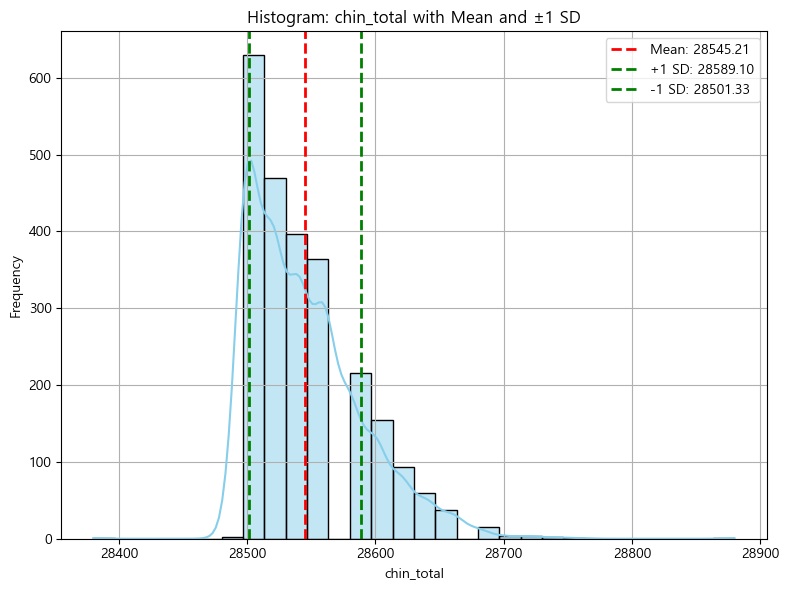

In [5]:
target = 'chin_total'
# Calculate statistics
mean_val = df[target].mean()
std_val = df[target].std()

# Plot histogram
plt.figure(figsize=(8, 6))
sns.histplot(df[target], bins=30, kde=True, color='skyblue', edgecolor='black')

# Add mean line
plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')

# Add standard deviation lines
plt.axvline(mean_val + std_val, color='green', linestyle='--', linewidth=2, label=f'+1 SD: {mean_val + std_val:.2f}')
plt.axvline(mean_val - std_val, color='green', linestyle='--', linewidth=2, label=f'-1 SD: {mean_val - std_val:.2f}')

# Titles and labels
plt.title("Histogram: chin_total with Mean and ±1 SD")
plt.xlabel("chin_total")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

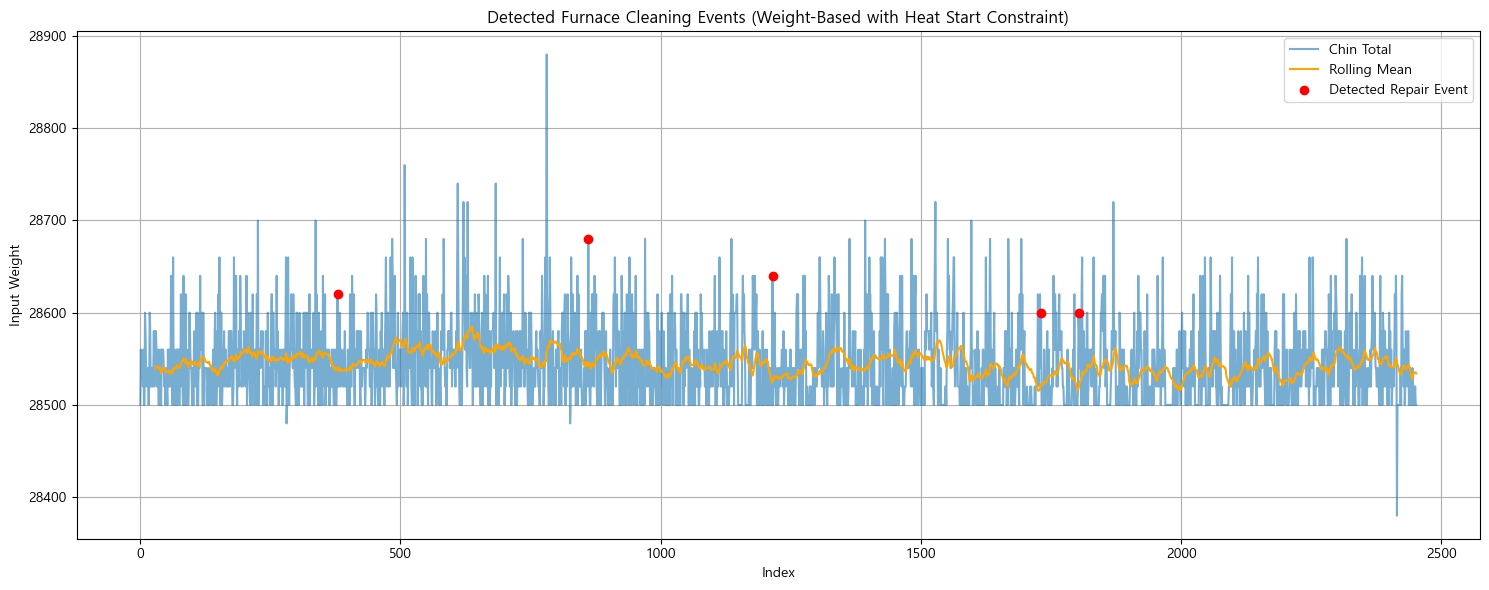

In [9]:
# Set rolling window size based on sampling rate (e.g., ~10 points/day → ~5 days = 50 points)
window_size = 30

# Compute rolling average and std deviation
df['rolling_mean'] = df['chin_total'].rolling(window=window_size, min_periods=window_size).mean()
df['rolling_std'] = df['chin_total'].rolling(window=window_size, min_periods=window_size).std()

# Compute z-score to identify spikes
df['z_score'] = (df['chin_total'] - df['rolling_mean']) / df['rolling_std']

# Define a spike threshold and apply '연회회수 == 1' condition
z_threshold = 2.0
df['potential_repair'] = (df['z_score'] > z_threshold) & (df['연회회수'] == 1)

# Add a declining trend condition (10-step backward difference in mean)
df['rolling_trend'] = df['rolling_mean'] - df['rolling_mean'].shift(10)
df['preceding_decline'] = df['rolling_trend'] < 0

# Combine conditions: spike + prior decline + heat sequence start
df['final_repair_flag'] = df['potential_repair'] & df['preceding_decline']

# Filter for minimum spacing between events (e.g., at least 30 indices apart)
event_indices = df.index[df['final_repair_flag']].tolist()
filtered_events = []
min_gap = 30
for idx in event_indices:
    if not filtered_events or (idx - filtered_events[-1]) > min_gap:
        filtered_events.append(idx)
df['filtered_repair'] = df.index.isin(filtered_events)

# Plot result
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(df['chin_total'], label='Chin Total', alpha=0.6)
plt.plot(df['rolling_mean'], label='Rolling Mean', color='orange')
plt.scatter(df.index[df['filtered_repair']], df.loc[df['filtered_repair'], 'chin_total'],
            color='red', label='Detected Repair Event', zorder=5)
plt.legend()
plt.title('Detected Furnace Cleaning Events (Weight-Based with Heat Start Constraint)')
plt.xlabel('Index')
plt.ylabel('Input Weight')
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
# Apply minimum spacing between events
filtered_events = []
for idx in event_indices:
    if not filtered_events or (idx - filtered_events[-1]) > min_gap:
        filtered_events.append(idx)

# Final list of indices for detected events
print(filtered_events)

[379, 861, 1215, 1731, 1803]


In [11]:
repair_dates = df.loc[filtered_events, '날짜'].tolist()

# Print the list of dates
print(repair_dates)

['2024-02-22', '2024-05-04', '2024-06-18', '2024-09-08', '2024-09-16']
